# Earthquake location

In this lab we will do some simple earthquake location, using an homogeneous velocity model. We will start with some synthetic data, then move onto adding noise, and finally work with some real arrival times.

The point of this lab is not to teach you the maths behind inverse theory (that is saved for MATH323), rather we want you to get a feel for when earthquake locations are well constrained, and when they are less likely to be.

Finally you should complete the recommended reading at the bottom of the lab.

# Basic theory

There are multiple ways to locate an earthquake, and multiple types of earthquake location.  We will mostly
consider hypocentre locations here. A light introduction to the theory behind earthquake location can be found in Section 7.2 of Stein and Wysession.

The hypocentre of an earthquake is the location that the earthquake starts (in contrast to the centroid location,
which is generally the centre of energy release of the earthquake). We can use the phase arrival picks we
made when picking last week to constrain the hypocentre. We know from our ray-tracing that, if we know the velocity model, we can work out how long it takes for a ray to travel from the earthquake source to our receiver.  If we have multiple receivers then we can triangulate the location of the earthquake. However, to do that we also need to know the origin time of the earthquake. When we think about solving for an earthquake location we need to remember
that we are finding the source in both **space and time**.

If we know the time of arrival of the P and S phases we can try and work out the distance from our receiver to
the source, but this assumes that the P and S waves follow the same ray-path.  Often the difference is small,
but real.

The way that we generally locate earthquakes is to invert for the location. There are multiple schemes for how to
invert the data: we will just think about simple linearised inversion here, but those taking GPHS446 will see
other inversion methods. Linearised inversion works reasonably well for earthquakes that are not close to
the surface, are surrounded by receivers, and are within a smooth velocity structure.

In a simple homogeneous halfspace the arrival time of a given phase is given by simple trig:

\begin{equation*}
    t_i = T + \frac{\sqrt{(x - x_i)^2 + (y - y_i)^2 + (z - z_i)^2}}{v}
\end{equation*}

where subscript i denotes the $i^{th}$ station, x, y, z are the hypocentre co-ordinates, T is the origin time
and v is the wave velocity.

<img alt="Stein and Wysession Fig 7.2.1" align="centre" style="width:40%" src="http://levee.wustl.edu/seismology/book/chapter7/chap7_sr/7_2_01_s.jpg">

We will use this example of a 2D linear inversion to demonstrate the theory, however there are much better ways to actually locate earthquakes, with more complex and realistic velocity models. There are also many other ways to locate earthquakes, including exhaustive grid searches or less exhaustive grid searches that sample only some of the model space. We can also *relocate* earthquakes by refining their relative locations compared to other events (usually via double-difference methods).

## Introduction to inverse theory

\begin{equation*}
    d=Fm
\end{equation*}
where $d$ is the data (observations), $F$ is some function (a mathematical representation of the physics), and
$m$ is the model. In the case of earthquake location, $d$ is our observations of phase arrival times, 
$m$ is our model of the earthquake location and $F$ is our system of equations linking observations and model.

When we locate earthquakes we seek to minimize the error between what our modeled location predicts the arrival
times to be, and what we observe the arrival times to be.  We do not have perfect knowledge of the velocity
structure of the Earth, nor do we have perfect data (we have noise, so our pick-times will have some uncertainty),
so we are unlikely to get a perfect fit between our model and our data. In particular this leads to a system of
*inconsistent* equations. Our error is:

\begin{equation*}
    e_i = d^{obs}_i - d^{cal}_i
\end{equation*}

where $obs$ denotes our observations and $cal$ marks our calculated arrival times. We need to have at least four
observations to have a well constrained system of equations (given our four unknowns of X, Y, Z and T). Commonly
we will have more than four observations which leads to an *overdetermined* system. To solve an *overdetermined* and *inconsistent* set of equations there is no perfect model, instead we seek the *best* solution. To find the *best* location we seek to minimize:

\begin{equation*}
    E = e^Te
\end{equation*}
which is the L2 norm. Other choices of norm are available and are made use of by different location methods.

To find the best fitting location we can either search through a series of forward-models (where some location
and origin time are set and the arrival times calculated), or iteratively search for the best model from
some starting model. Here we will consider the iterative method; this is more computationally efficient,
but is more susceptible to finding local minima as solutions. In this approach have to make a *guess* at
the location and iteratively improve our model.  For local seismicity it is common to use a starting 
model close to the seismograph with the first arrival at some set depth.

To find the *best* solution we compute the partial derivatives of our system and move towards a minima in
error. However, in even the homogeneous half-space case, the equations are non-linear: the arrival time 
depends linearly on distance and origin-time, but not on hypocentral location. The way that we will 
solve this is to *linearize* the equation by taking the Taylor-series expansion and discarding all 
higher order terms. 

When we do this we find that the parital derivatives of the travel time are of the form:

\begin{equation*}
    \frac{\delta t}{\delta X} = \frac{(x - x_i)}{v\sqrt{(x - x_i)^2 + (y - y_i)^2 + (z - z_i)^2}}
\end{equation*}
with similar equations for $y$ and $z$.

These partial derivatives tell us the direction towards the next minima: we can compute the unit vector
pointing towards the minima as:
\begin{equation*}
    \nu = -\frac{\nabla E}{|\nabla E|}
\end{equation*}

## Implementation

I have written a simple, undamped linearised location program in Python in the `geiger_location.py` file.
We can call this and give it a go - it will produce plots of the location history.

To start with lets start with the perfectly determined case.

In [1]:
# First, some set up!

%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# My code uses the "logging" module to control output. If you want more output set level=logging.DEBUG
import logging

logging.basicConfig(
    format="%(name)s\t%(levelname)s\t%(message)s", 
    level=logging.INFO)

Geiger	INFO	Starting model has residual of 3.18
Geiger	INFO	Model updated to: (time 0.31, x 10.59, y 4.34 z 11.57)
Geiger	INFO	Updated model has residual of 0.70
Geiger	INFO	Model updated to: (time -0.00, x 10.02, y 4.00 z 12.02)
Geiger	INFO	Updated model has residual of 0.01
Geiger	INFO	Model updated to: (time 0.00, x 10.00, y 4.00 z 12.00)
Geiger	INFO	Updated model has residual of 0.00
Geiger	INFO	Model has reached convergence threshold


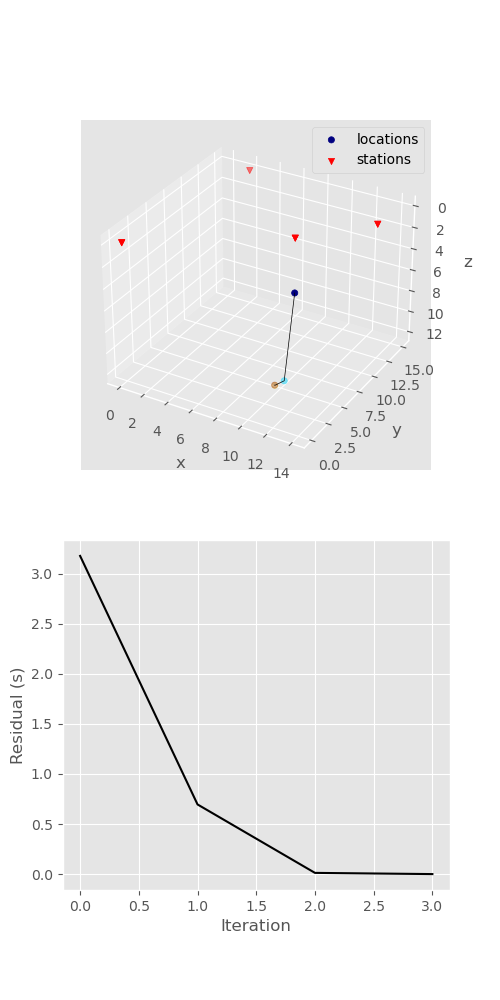

Found a solution at x = 10.00, y = 4.00, z = 12.00, time = 0.00


In [2]:
import numpy as np

from gphs445_utilities.location import geiger_locate

known_location = {"x": 10.0, "y": 4.0, "z": 12.0, "time": 0.0}
vp = 5.0
vs = 3.0

stations = [
    {"x": 0, "y": 0, "z": 0},
    {"x": 2, "y": 15, "z": 0},
    {"x": 10, "y": 7, "z": 0},
    {"x": 14, "y": 12, "z": 0}]

p_times = np.zeros(len(stations))
s_times = np.zeros_like(p_times)

for i, station in enumerate(stations):
    distance = (
        (station["x"] - known_location["x"]) ** 2 +
        (station["y"] - known_location["y"]) ** 2 + 
        (station["z"] - known_location["z"]) ** 2) ** 0.5
    p_times[i] = distance / vp
    s_times[i] = distance / vs

inverted_model = geiger_locate(
    p_times=p_times, p_locations=stations, s_times=s_times,
    s_locations=stations, vp=vp, vs=vs, starting_depth=5.0, plot=True)

print("Found a solution at x = {0:.2f}, y = {1:.2f}, z = {2:.2f}, "
      "time = {3:.2f}".format(inverted_model["x"], inverted_model["y"],
                              inverted_model["z"], inverted_model["time"]))

Lets try adding noise to the data.

Geiger	INFO	Starting model has residual of 3.85
Geiger	INFO	Model updated to: (time 0.80, x 8.88, y 4.02 z 8.97)
Geiger	INFO	Updated model has residual of 0.73
Geiger	INFO	Model updated to: (time 0.76, x 8.25, y 3.84 z 8.48)
Geiger	INFO	Updated model has residual of 0.55
Geiger	INFO	Model updated to: (time 0.76, x 8.27, y 3.86 z 8.44)
Geiger	INFO	Updated model has residual of 0.55
Geiger	INFO	Model has reached convergence threshold


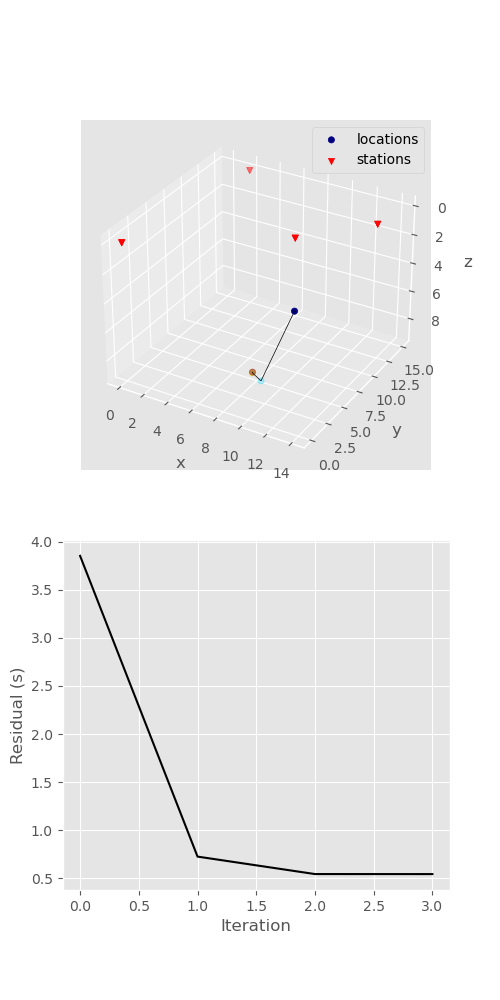

Solution at x = 8.27, y = 3.86, z = 8.44, time = 0.76


In [3]:
np.random.seed(42)
p_times = [time + np.random.sample() - .5 for time in p_times]
s_times = [time + np.random.sample() - .5 for time in s_times]

inverted_model = geiger_locate(
    p_times=p_times, p_locations=stations, s_times=s_times,
    s_locations=stations, vp=vp, vs=vs, starting_depth=5.0, plot=True)

print("Solution at x = {0:.2f}, y = {1:.2f}, z = {2:.2f}, "
      "time = {3:.2f}".format(inverted_model["x"], inverted_model["y"],
                              inverted_model["z"], inverted_model["time"]))

We don't get perfectly back to our initial location when we add noise in the range (-0.5, 0.5), unsurprisngly.

How about making it overdetermined?

Geiger	INFO	Starting model has residual of 6.03
Geiger	INFO	Model updated to: (time 0.21, x 10.10, y 4.44 z 11.89)
Geiger	INFO	Updated model has residual of 1.63
Geiger	INFO	Model updated to: (time -0.09, x 10.30, y 3.96 z 12.07)
Geiger	INFO	Updated model has residual of 1.11
Geiger	INFO	Model updated to: (time -0.09, x 10.30, y 3.95 z 12.06)
Geiger	INFO	Updated model has residual of 1.11
Geiger	INFO	Model updated to: (time -0.09, x 10.30, y 3.95 z 12.06)
Geiger	INFO	Updated model has residual of 1.11
Geiger	INFO	Model updated to: (time -0.09, x 10.30, y 3.95 z 12.06)
Geiger	INFO	Updated model has residual of 1.11
Geiger	INFO	Model has reached convergence threshold


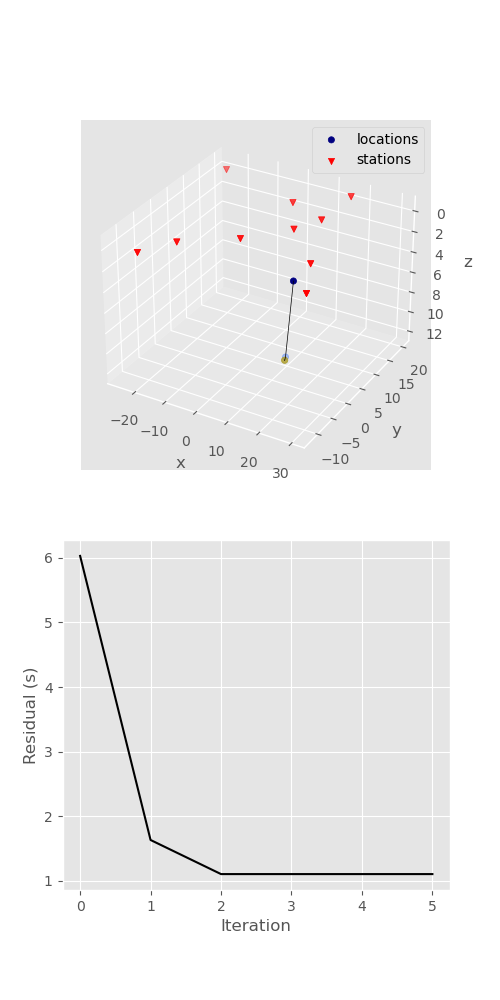

Found a solution at x = 10.30, y = 3.95, z = 12.06, time = -0.09


In [4]:
stations = [
    {"x": 0, "y": 0, "z": 0},
    {"x": 2, "y": 15, "z": 0},
    {"x": 10, "y": 7, "z": 0},
    {"x": 14, "y": 12, "z": 0},
    {"x": 20, "y": 2, "z": 1.2},
    {"x": 16, "y": 20, "z": -0.5},
    {"x": -20, "y": -12, "z": 0},
    {"x": -14, "y": -6, "z": 0},
    {"x": 30, "y": -10, "z": 0},
    {"x": -25, "y": 20, "z": 0}]

p_times = np.zeros(len(stations))
s_times = np.zeros_like(p_times)

for i, station in enumerate(stations):
    distance = (
        (station["x"] - known_location["x"]) ** 2 +
        (station["y"] - known_location["y"]) ** 2 + 
        (station["z"] - known_location["z"]) ** 2) ** 0.5
    p_times[i] = distance / vp
    s_times[i] = distance / vs

p_times = [time + np.random.sample() - .5 for time in p_times]
s_times = [time + np.random.sample() - .5 for time in s_times]
    
inverted_model = geiger_locate(
    p_times=p_times, p_locations=stations, s_times=s_times,
    s_locations=stations, vp=vp, vs=vs, convergence=0.00001, 
    starting_depth=5.0, plot=True)

print("Found a solution at x = {0:.2f}, y = {1:.2f}, z = {2:.2f}, "
      "time = {3:.2f}".format(inverted_model["x"], inverted_model["y"],
                              inverted_model["z"], inverted_model["time"]))

We don't get a much better location, but we are able to get close, despite the noise.


Now it is your turn. Try the following with noise and without:

1. Try starting the location at a depth of 100km for a simulated earthquake at 10 km depth - does the inversion converge?
2. Try to locate an earthquake at 5 km depth, 10 km outside your set of stations, e.g. all the stations should be on one side of the earthquake - how well resolved is the final location and why?
3. Try to locate an earthquake that is shallower than half the distance to the nearest station - how well resolved is the final location and why?

In [5]:
# Your code here.

Lets try a real earthquake from GeoNet and see how well the simple model does.

Geiger	INFO	Starting model has residual of 15.90
Geiger	INFO	Model updated to: (time -3.18, x 9.45, y -5.84 z 17.34)
Geiger	INFO	Updated model has residual of 3.19
Geiger	INFO	Model updated to: (time -3.35, x 9.41, y -5.61 z 15.39)
Geiger	INFO	Updated model has residual of 2.80
Geiger	INFO	Model updated to: (time -3.35, x 9.42, y -5.61 z 15.23)
Geiger	INFO	Updated model has residual of 2.80
Geiger	INFO	Model updated to: (time -3.35, x 9.42, y -5.61 z 15.22)
Geiger	INFO	Updated model has residual of 2.80
Geiger	INFO	Model has reached convergence threshold


We have 7 S picks and 15 P picks.


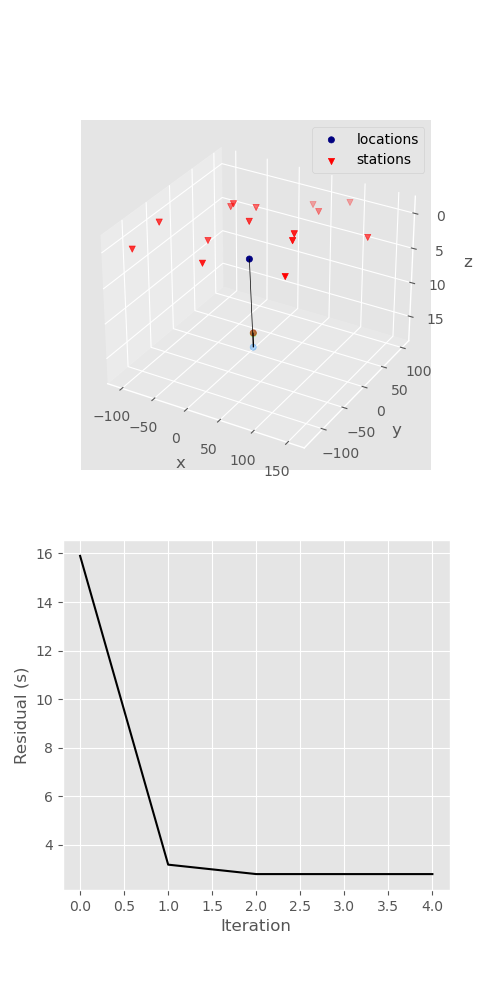

GeoNet location: -44.27 latitude, 169.36 longitude, 5.26 depth (km) 2019-05-08T20:03:32.781766Z origin time
Homogeneous model location: -44.28 latitude, 169.35 longitude, 15.22 depth (km) 2019-05-08T20:03:32.479961Z origin time


In [6]:
from gphs445_utilities.location import geiger_locate_lat_lon
from obspy.clients.fdsn import Client

client = Client("GEONET")
event = client.get_events(eventid="2019p345502")[0]
bulk = [
    (pick.waveform_id.network_code, pick.waveform_id.station_code,
     pick.waveform_id.location_code, pick.waveform_id.channel_code, 
     pick.time - 300, pick.time + 300) for pick in event.picks]
inventory = client.get_stations_bulk(bulk, level="channel")

p_times, p_locations, s_times, s_locations = ([], [], [], [])

for pick in event.picks:
    try:
        loc = inventory.get_coordinates(pick.waveform_id.get_seed_string())
    except:
        print("No location found for {0}".format(
            pick.waveform_id.get_seed_string()))
        continue
    if pick.phase_hint == "P":
        p_times.append(pick.time)
        p_locations.append(
            {"lat": loc["latitude"], "lon": loc["longitude"], 
             "z": loc["elevation"] / 1000.})
    elif pick.phase_hint == "S":
        s_times.append(pick.time)
        s_locations.append(
            {"lat": loc["latitude"], "lon": loc["longitude"], 
             "z": loc["elevation"] / 1000.})

print(f"We have {len(s_times)} S picks and {len(p_times)} P picks.")

model = geiger_locate_lat_lon(p_times, p_locations, s_times, s_locations, vp=5.8,
                              vs=3.36, plot=True, starting_depth=5.)

print("GeoNet location: {0:.2f} latitude, {1:.2f} longitude, {2:.2f} depth (km) {3} origin time".format(
    event.preferred_origin().latitude, event.preferred_origin().longitude,
    event.preferred_origin().depth / 1000., event.preferred_origin().time))
print("Homogeneous model location: {0:.2f} latitude, {1:.2f} longitude, {2:.2f} depth (km) {3} origin time".format(
    model["lat"], model["lon"], model["z"], model["time"]))

The homogeneous location is epicentrally close to GeoNet location, but 10 km deeper! It turns out that the GeoNet event was located using a linearised inversion, without weights, and in the IASP91 velocity model. The IASP91 velocity model looks like this:

<img alt="IASP91 global 1D velocity model" align="centre" style="width:40%" src="http://ds.iris.edu/spudservice/data/9991806?nolog=y">

For the upper 20 km the P-wave velocity in IASP91 is 5.8 km/s and S-wave velocity is 3.36 km/s, as we have used above. So why the difference in depths? On closer inspection of the SeisComp files it looks like a mistake in the S travel-time tables for shallow earthquakes (if you want to look at these travel-time tables see [here](https://github.com/SeisComP/common/blob/master/libs/3rd-party/locsat/data/iasp91.S) where there is a negative travel-time for 0km depth S-arrivals).  

In this fairly unusual situation (good azimuthal coverage in P and S arrivals, and a reasonable number of nearby stations) we can simulate this error by subtracting time from our S-pick times - I found about 2.4 s works...

Geiger	INFO	Starting model has residual of 18.77
Geiger	INFO	Model updated to: (time -3.21, x 8.49, y -4.42 z 12.40)
Geiger	INFO	Updated model has residual of 6.07
Geiger	INFO	Model updated to: (time -3.04, x 8.85, y -4.80 z 5.25)
Geiger	INFO	Updated model has residual of 5.86
Geiger	INFO	Model updated to: (time -3.12, x 8.83, y -4.66 z 5.34)
Geiger	INFO	Updated model has residual of 5.85
Geiger	INFO	Model updated to: (time -3.12, x 8.83, y -4.66 z 5.35)
Geiger	INFO	Updated model has residual of 5.85
Geiger	INFO	Model has reached convergence threshold


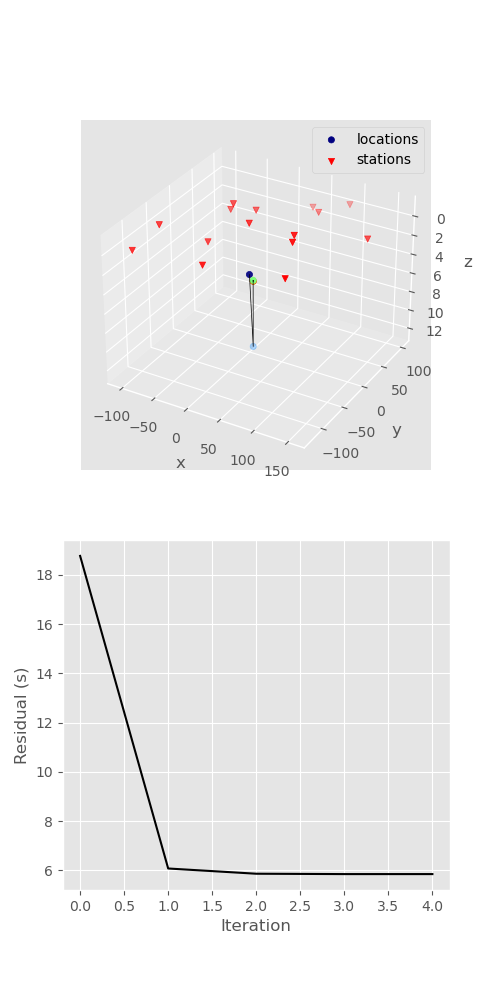

Homogeneous model (fudged) location: -44.27 latitude, 169.34 longitude, 5.35 depth (km) 2019-05-08T20:03:32.174947Z origin time


In [7]:
s_times_fudged = [s_time - 2.4 for s_time in s_times]

model_fudged = geiger_locate_lat_lon(p_times, p_locations, s_times_fudged, s_locations, vp=5.8,
                                     vs=3.36, plot=True, starting_depth=5.)

print("Homogeneous model (fudged) location: {0:.2f} latitude, {1:.2f} longitude, {2:.2f} depth (km) {3} origin time".format(
    model_fudged["lat"], model_fudged["lon"], model_fudged["z"], model_fudged["time"]))

When I locate this earthquake in the iasp91 velocity model in a different program (*hypocentre*) I end up with a location somewhere in the middle at 13.8 km depth, closer to mine than GeoNet. The main difference between my location and the *hypocentre* derived location is that *hypocentre* incorporates refracted arrivals - for more distant stations the PN arrival ends up being first.

Lets have a play with this and look at the trade-off between depth and origin time for one station by calculating the expected first arrival for one station with varying depths. We can use ObsPy's intergration of the TauP program to calculate travel-times.

In [8]:
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth, kilometers2degrees

iasp_model = TauPyModel("iasp91")

def get_traveltime(lat, lon, depth, station_lat, station_lon):  
    dist, _, _ = gps2dist_azimuth(station_lat, station_lon, lat, lon)
    dist /= 1000.0
    dist = kilometers2degrees(dist)
    arrivals = iasp_model.get_travel_times(
            source_depth_in_km=depth, distance_in_degree=dist)
    return arrivals

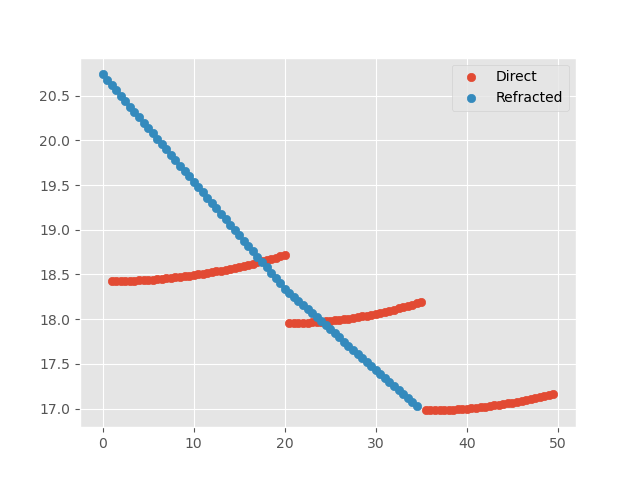

In [9]:
import numpy as np

station_name = "EAZ"

lat, lon = -44.27, 169.36
depths = np.arange(0, 50, 0.5)

station = inventory.select(station=station_name)[0][0]

direct_p, moho_p = [], []

for depth in depths:
    arrivals = get_traveltime(lat, lon, depth, station.latitude, station.longitude)
    _direct = [arr for arr in arrivals if arr.name == "p"]
    _moho = [arr for arr in arrivals if arr.name == "Pn"]
    if len(_direct) == 0:
        direct_p.append(np.nan)
    else:
        direct_p.append(_direct[0].time)
    if len(_moho) == 0:
        moho_p.append(np.nan)
    else:
        moho_p.append(_moho[0].time)
        
        
fig, ax = plt.subplots()
ax.scatter(depths, direct_p, label="Direct")
ax.scatter(depths, moho_p, label="Refracted")
ax.legend()

Try playing around with different stations - what do you think these sharp velocity boundaries do to the inversion process?

We can also look at the range of phases that we would expect below:

0.9611721185780557


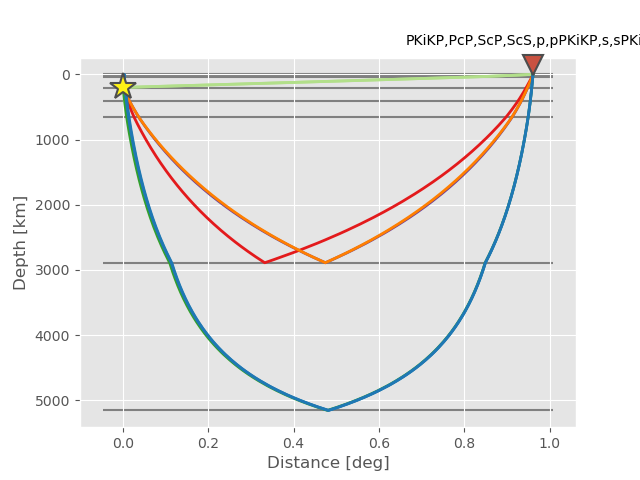

In [10]:
station_lat, station_lon = station.latitude, station.longitude
dist, _, _ = gps2dist_azimuth(station_lat, station_lon, lat, lon)
dist /= 1000.0
dist = kilometers2degrees(dist)
print(dist)
arrivals = iasp_model.get_ray_paths(
    source_depth_in_km=200, distance_in_degree=dist, phase_list=["ttbasic"])

ax = arrivals.plot_rays(plot_type="cartesian", plot_all=False, label_arrivals=True)